In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from models import Bin, Five

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_curve, RocCurveDisplay, auc
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

In [26]:
class2idxBin = {
    "control":0,
    "diseases":1,
}

idx2classBin = {v: k for k, v in class2idxBin.items()}

class2idxFive = {
    "CRC":0,
    "Lung":1,
    "Gastric":2,
    "Liver":3,
    "Breast":4
}

idx2classFive = {v: k for k, v in class2idxFive.items()}

class2idxSix = {
    "CRC":0,
    "Control":1,
    "Lung":2,
    "Gastric":3,
    "Liver":4,
    "Breast":5
}

idx2classSix = {v: k for k, v in class2idxSix.items()}

testloader = []

with open('data/val_bin.npy', 'rb') as f:
    x_test0 = np.load(f)
with open('data/val_bin_target.npy', 'rb') as f:
    y_test0 = np.load(f)

with open('data/test_bin.npy', 'rb') as f:
    x_test1 = np.load(f)
with open('data/test_bin_target.npy', 'rb') as f:
    y_test1 = np.load(f)

x_test_bin = np.concatenate([x_test0, x_test1])
y_test_bin = np.concatenate([y_test0, y_test1])

with open('data/val_five.npy', 'rb') as f:
    x_test0 = np.load(f)
with open('data/val_five_target.npy', 'rb') as f:
    y_test0 = np.load(f)

with open('data/test_five.npy', 'rb') as f:
    x_test1 = np.load(f)
with open('data/test_five_target.npy', 'rb') as f:
    y_test1 = np.load(f)

x_test_five = np.concatenate([x_test0, x_test1])
y_test_five = np.concatenate([y_test0, y_test1])

x_test = x_test_five.copy()
y_test = y_test_five.copy()
for i,v in enumerate(y_test_five):
    if v > 0:
        y_test[i] += 1

for i,v in enumerate(y_test_bin):
    if v == 0:
        np.vstack([x_test, x_test_bin[i]])
        y_test = np.append(y_test, 1)

randomize = np.arange(len(x_test))
np.random.shuffle(randomize)
x_test = x_test[randomize]
y_test = y_test[randomize]

Accuracy five: 0.9649122807017544
F1 score five: 0.9185714285714286
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.98      0.98      0.98        50

    accuracy                           0.96        57
   macro avg       0.92      0.92      0.92        57
weighted avg       0.96      0.96      0.96        57



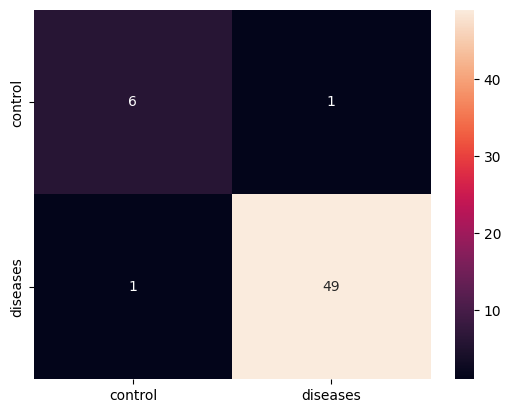

In [30]:
checkpoint_path="checkpoints/ckp_bin.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Bin()
checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint_dict['net'])
model.to(device)

y_pred_list = []

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


test_dataset = ClassifierDataset(torch.from_numpy(x_test_bin).float(), torch.from_numpy(y_test_bin).long())

testloader = DataLoader(dataset=test_dataset, batch_size=1)

with torch.no_grad():
    model.eval()
    for X_batch, _ in testloader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print(f'Accuracy five: {accuracy_score(y_test_bin, y_pred_list)}')

f1 = f1_score(y_test_bin, y_pred_list, average='macro')
print(f'F1 score five: {f1}')
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_bin, y_pred_list)).rename(columns=idx2classBin, index=idx2classBin)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_bin, y_pred_list))

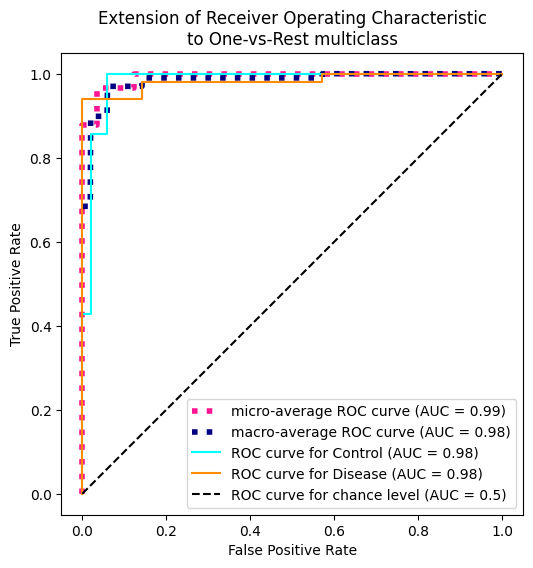

In [31]:
y_score = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in testloader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        tmp = y_test_pred.cpu().numpy()[0]
        lst = [-l/sum(tmp) for l in tmp]
        y_score.append(lst)
y_score = np.array(y_score)
n_classes = 2
target_names = np.array(["Control","Disease"])

y_onehot_test = np.array([[1,0] if l==0 else [0,1] for l in y_test_bin])
fpr_grid = np.linspace(0.0, 1.0, 1000)
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()

Accuracy five: 0.75
F1 score five: 0.7448728773806172
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.88      0.78      0.82         9
           2       0.70      0.78      0.74         9
           3       0.83      1.00      0.91        10
           4       0.71      0.50      0.59        10

    accuracy                           0.75        48
   macro avg       0.75      0.75      0.74        48
weighted avg       0.75      0.75      0.74        48



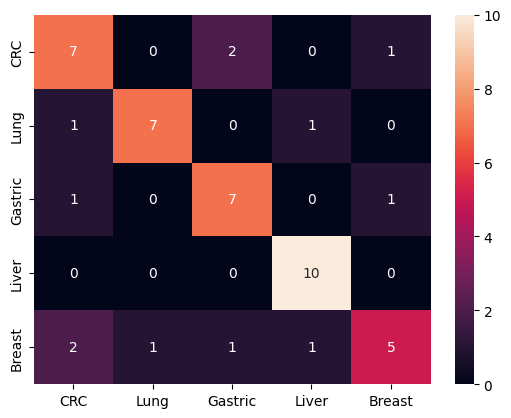

In [32]:
checkpoint_path="checkpoints/ckp_five.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Five()
checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint_dict['net'])
model.to(device)

y_pred_list = []

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


test_dataset = ClassifierDataset(torch.from_numpy(x_test_five).float(), torch.from_numpy(y_test_five).long())

testloader = DataLoader(dataset=test_dataset, batch_size=1)

with torch.no_grad():
    model.eval()
    for X_batch, _ in testloader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print(f'Accuracy five: {accuracy_score(y_test_five, y_pred_list)}')

f1 = f1_score(y_test_five, y_pred_list, average='macro')
print(f'F1 score five: {f1}')
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_five, y_pred_list)).rename(columns=idx2classFive, index=idx2classFive)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_five, y_pred_list))

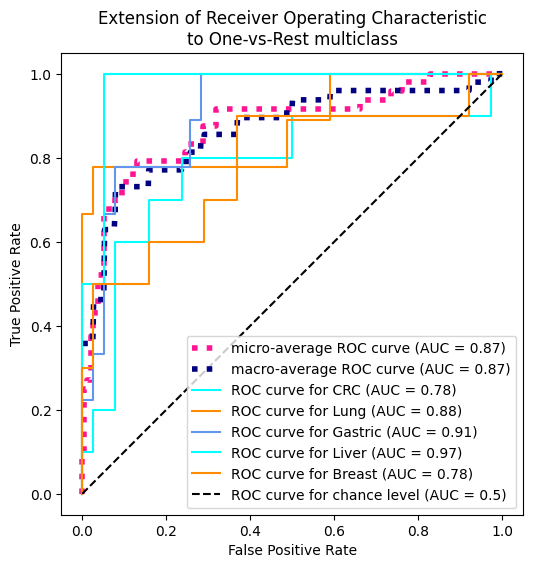

In [33]:
y_score = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in testloader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        tmp = y_test_pred.cpu().numpy()[0]
        lst = [-l/sum(tmp) for l in tmp]
        y_score.append(lst)
y_score = np.array(y_score)

n_classes = 5
target_names = np.array(["CRC","Lung","Gastric","Liver","Breast"])

label_binarizer = LabelBinarizer().fit(y_test_five)
y_onehot_test = label_binarizer.transform(y_test_five)
fpr_grid = np.linspace(0.0, 1.0, 1000)
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()

# Machine Learning

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_curve, RocCurveDisplay, auc
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

In [2]:
# load the model from disk
filename = 'checkpoints/ml_svm_bin.sav'
svm_bin = pickle.load(open(filename, 'rb'))
filename = 'checkpoints/ml_rf_bin.sav'
rf_bin = pickle.load(open(filename, 'rb'))
filename = 'checkpoints/ml_knn_bin.sav'
knn_bin = pickle.load(open(filename, 'rb'))

filename = 'checkpoints/ml_svm_five.sav'
svm_five = pickle.load(open(filename, 'rb'))
filename = 'checkpoints/ml_rf_five.sav'
rf_five = pickle.load(open(filename, 'rb'))
filename = 'checkpoints/ml_knn_five.sav'
knn_five = pickle.load(open(filename, 'rb'))

class2idxBin = {
    "control":0,
    "diseases":1,
}

idx2classBin = {v: k for k, v in class2idxBin.items()}

class2idxFive = {
    "CRC":0,
    "Lung":1,
    "Gastric":2,
    "Liver":3,
    "Breast":4
}

idx2classFive = {v: k for k, v in class2idxFive.items()}

class2idxSix = {
    "CRC":0,
    "Control":1,
    "Lung":2,
    "Gastric":3,
    "Liver":4,
    "Breast":5
}

idx2classSix = {v: k for k, v in class2idxSix.items()}

testloader = []

with open('data/val_bin.npy', 'rb') as f:
    x_test0 = np.load(f)
with open('data/val_bin_target.npy', 'rb') as f:
    y_test0 = np.load(f)

with open('data/test_bin.npy', 'rb') as f:
    x_test1 = np.load(f)
with open('data/test_bin_target.npy', 'rb') as f:
    y_test1 = np.load(f)

x_test_bin = np.concatenate([x_test0, x_test1])
y_test_bin = np.concatenate([y_test0, y_test1])

with open('data/val_five.npy', 'rb') as f:
    x_test0 = np.load(f)
with open('data/val_five_target.npy', 'rb') as f:
    y_test0 = np.load(f)

with open('data/test_five.npy', 'rb') as f:
    x_test1 = np.load(f)
with open('data/test_five_target.npy', 'rb') as f:
    y_test1 = np.load(f)

x_test_five = np.concatenate([x_test0, x_test1])
y_test_five = np.concatenate([y_test0, y_test1])

x_test = x_test_five.copy()
y_test = y_test_five.copy()
for i,v in enumerate(y_test_five):
    if v > 0:
        y_test[i] += 1

for i,v in enumerate(y_test_bin):
    if v == 0:
        np.vstack([x_test, x_test_bin[i]])
        y_test = np.append(y_test, 1)

randomize = np.arange(len(x_test))
np.random.shuffle(randomize)
x_test = x_test[randomize]
y_test = y_test[randomize]

Accuracy SVM bin: 0.8947368421052632
F1 score SVM bin: 0.7205882352941176
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.92      0.96      0.94        50

    accuracy                           0.89        57
   macro avg       0.76      0.69      0.72        57
weighted avg       0.88      0.89      0.89        57



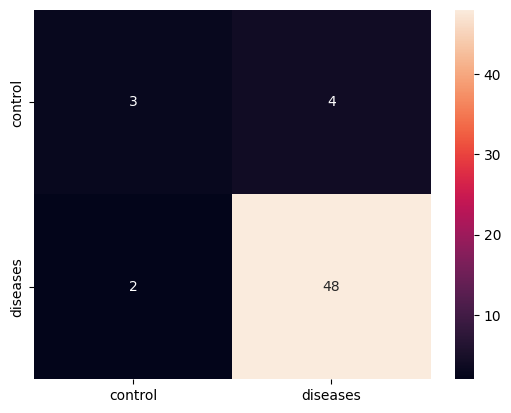

In [3]:
print(f'Accuracy SVM bin: {accuracy_score(y_test_bin, svm_bin.predict(x_test_bin))}')

f1_svm = f1_score(y_test_bin, svm_bin.predict(x_test_bin), average='macro')
print(f'F1 score SVM bin: {f1_svm}')

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_bin, svm_bin.predict(x_test_bin))).rename(columns=idx2classBin, index=idx2classBin)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_bin, svm_bin.predict(x_test_bin)))

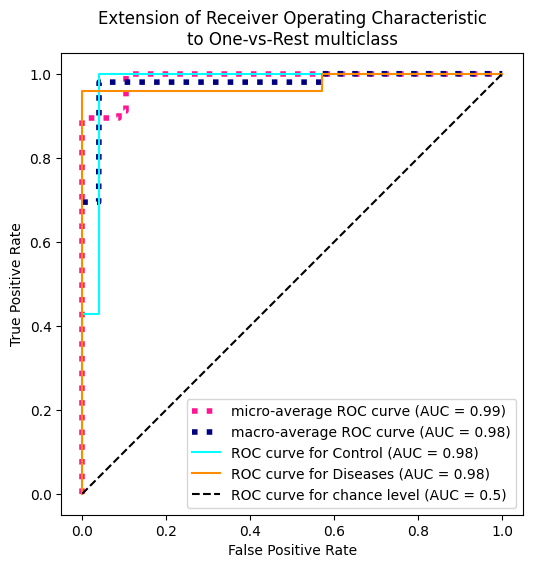

In [4]:
n_classes = 2
target_names = np.array(["Control","Diseases"])
y_score = svm_bin.predict_proba(x_test_bin)

y_onehot_test = np.array([[1,0] if l==0 else [0,1] for l in y_test_bin])
fpr_grid = np.linspace(0.0, 1.0, 1000)
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()

Accuracy SVM five: 0.7083333333333334
F1 score SVM five: 0.7039628482972136
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.64      0.78      0.70         9
           2       0.62      0.56      0.59         9
           3       0.90      0.90      0.90        10
           4       0.70      0.70      0.70        10

    accuracy                           0.71        48
   macro avg       0.71      0.71      0.70        48
weighted avg       0.71      0.71      0.71        48



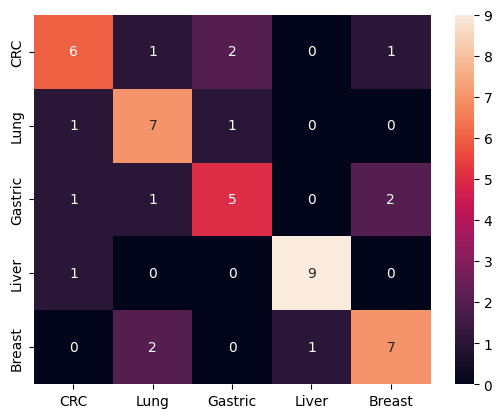

In [8]:
print(f'Accuracy SVM five: {accuracy_score(y_test_five, svm_five.predict(x_test_five))}')

f1_svm = f1_score(y_test_five, svm_five.predict(x_test_five), average='macro')
print(f'F1 score SVM five: {f1_svm}')

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_five, svm_five.predict(x_test_five))).rename(columns=idx2classFive, index=idx2classFive)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_five, svm_five.predict(x_test_five)))

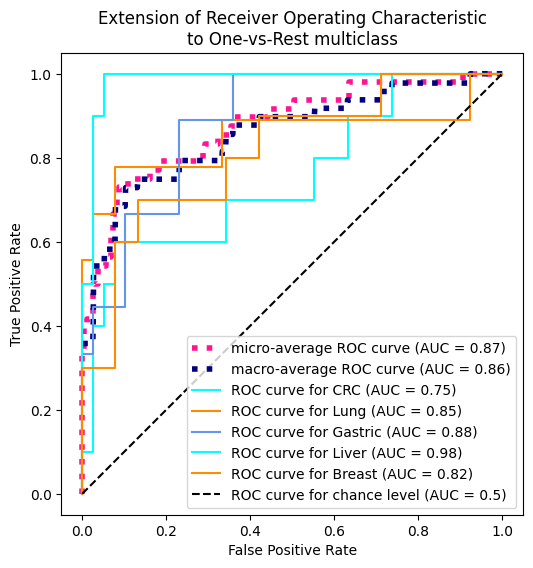

In [36]:
n_classes = 5
target_names = np.array(["CRC","Lung","Gastric","Liver","Breast"])
y_score = svm_five.predict_proba(x_test_five)

label_binarizer = LabelBinarizer().fit(y_test_five)
y_onehot_test = label_binarizer.transform(y_test_five)
fpr_grid = np.linspace(0.0, 1.0, 1000)
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()

Accuracy random forest bin: 0.8947368421052632
F1 score random forest bin: 0.6711538461538462
              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.91      0.98      0.94        50

    accuracy                           0.89        57
   macro avg       0.79      0.63      0.67        57
weighted avg       0.88      0.89      0.88        57



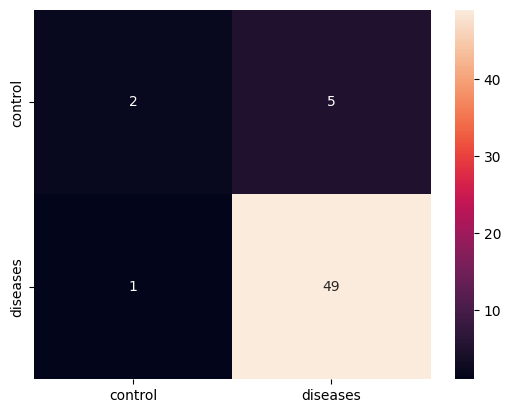

In [9]:
print(f'Accuracy random forest bin: {accuracy_score(y_test_bin, rf_bin.predict(x_test_bin))}')

f1_rf = f1_score(y_test_bin, rf_bin.predict(x_test_bin), average='macro')
print(f'F1 score random forest bin: {f1_rf}')

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_bin, rf_bin.predict(x_test_bin))).rename(columns=idx2classBin, index=idx2classBin)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_bin, rf_bin.predict(x_test_bin)))

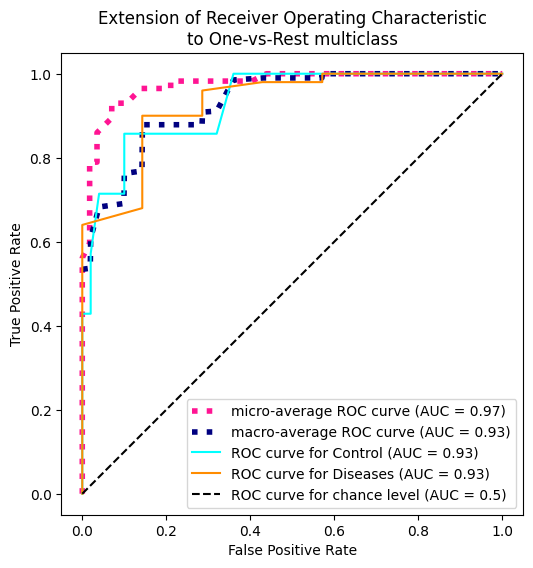

In [37]:
n_classes = 2
target_names = np.array(["Control","Diseases"])
y_score = rf_bin.predict_proba(x_test_bin)

y_onehot_test = np.array([[1,0] if l==0 else [0,1] for l in y_test_bin])
fpr_grid = np.linspace(0.0, 1.0, 1000)
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()

Accuracy random forest five: 0.5416666666666666
F1 score random forest five: 0.5200292397660818
              precision    recall  f1-score   support

           0       0.50      0.30      0.37        10
           1       0.40      0.44      0.42         9
           2       0.44      0.44      0.44         9
           3       0.71      1.00      0.83        10
           4       0.56      0.50      0.53        10

    accuracy                           0.54        48
   macro avg       0.52      0.54      0.52        48
weighted avg       0.53      0.54      0.52        48



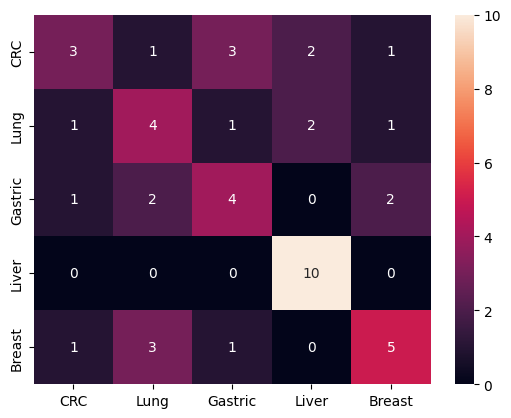

In [10]:
print(f'Accuracy random forest five: {accuracy_score(y_test_five, rf_five.predict(x_test_five))}')

f1_rf = f1_score(y_test_five, rf_five.predict(x_test_five), average='macro')
print(f'F1 score random forest five: {f1_rf}')

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_five, rf_five.predict(x_test_five))).rename(columns=idx2classFive, index=idx2classFive)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_five, rf_five.predict(x_test_five)))

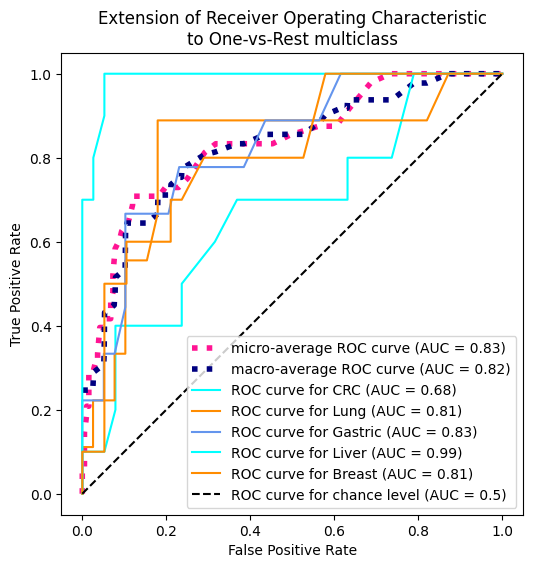

In [38]:
n_classes = 5
target_names = np.array(["CRC","Lung","Gastric","Liver","Breast"])
y_score = rf_five.predict_proba(x_test_five)

label_binarizer = LabelBinarizer().fit(y_test_five)
y_onehot_test = label_binarizer.transform(y_test_five)
fpr_grid = np.linspace(0.0, 1.0, 1000)
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()

Accuracy KNN bin: 0.9122807017543859
F1 score KNN bin: 0.8080808080808081
              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.96      0.94      0.95        50

    accuracy                           0.91        57
   macro avg       0.79      0.83      0.81        57
weighted avg       0.92      0.91      0.91        57



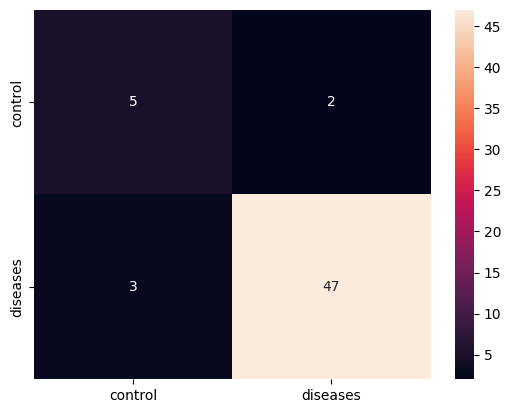

In [11]:
print(f'Accuracy KNN bin: {accuracy_score(y_test_bin, knn_bin.predict(x_test_bin))}')

f1_knn = f1_score(y_test_bin, knn_bin.predict(x_test_bin), average='macro')
print(f'F1 score KNN bin: {f1_knn}')

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_bin, knn_bin.predict(x_test_bin))).rename(columns=idx2classBin, index=idx2classBin)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_bin, knn_bin.predict(x_test_bin)))

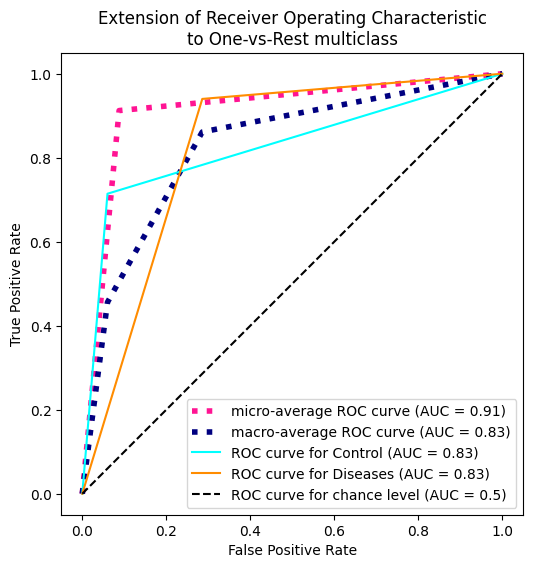

In [30]:
n_classes = 2
target_names = np.array(["Control","Diseases"])
y_score = knn_bin.predict_proba(x_test_bin)

y_onehot_test = np.array([[1,0] if l==0 else [0,1] for l in y_test_bin])
y_onehot_test.shape  # (n_samples, n_classes)
fpr_grid = np.linspace(0.0, 1.0, 1000)
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()

Accuracy KNN five: 0.3958333333333333
F1 score KNN five: 0.39862892525431226
              precision    recall  f1-score   support

           0       0.22      0.40      0.29        10
           1       0.14      0.11      0.12         9
           2       0.43      0.33      0.38         9
           3       0.78      0.70      0.74        10
           4       0.57      0.40      0.47        10

    accuracy                           0.40        48
   macro avg       0.43      0.39      0.40        48
weighted avg       0.43      0.40      0.40        48



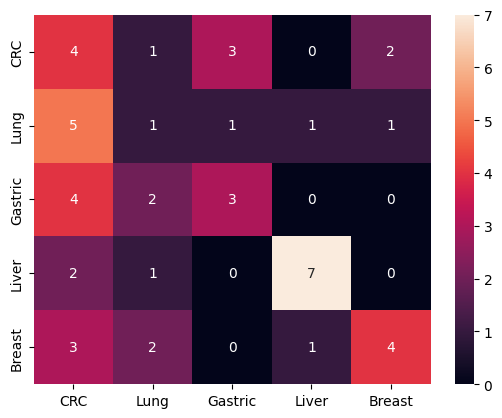

In [12]:
print(f'Accuracy KNN five: {accuracy_score(y_test_five, knn_five.predict(x_test_five))}')

f1_svm = f1_score(y_test_five, knn_five.predict(x_test_five), average='macro')
print(f'F1 score KNN five: {f1_svm}')

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_five, knn_five.predict(x_test_five))).rename(columns=idx2classFive, index=idx2classFive)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_five, knn_five.predict(x_test_five)))

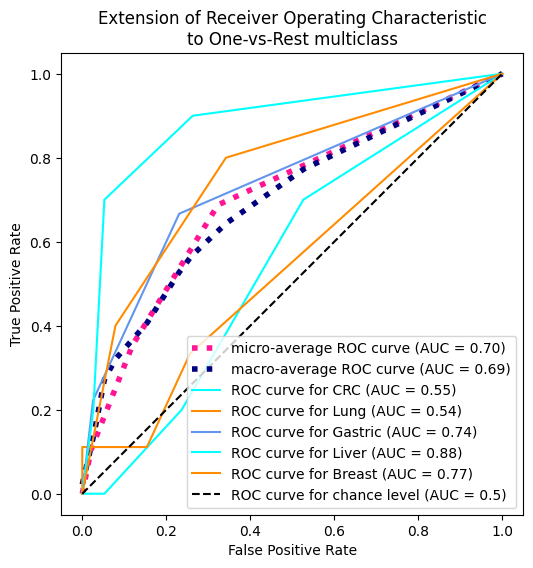

In [39]:
n_classes = 5
target_names = np.array(["CRC","Lung","Gastric","Liver","Breast"])
y_score = knn_five.predict_proba(x_test_five)

label_binarizer = LabelBinarizer().fit(y_test_five)
y_onehot_test = label_binarizer.transform(y_test_five)
fpr_grid = np.linspace(0.0, 1.0, 1000)
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()